# Исследовательская тетрадка по кластеризации

In [1]:
import os
import pandas as pd

from matplotlib import pyplot as plt
from plotly import express as px
from sklearn.cluster import DBSCAN, KMeans

from bank_schedule import data as bsd
from bank_schedule import plot as bsplot

from bank_schedule import helpers
from bank_schedule.constants import CENTER_LON, CENTER_LAT, RS

In [2]:
RAW_DATA_FOLDER = os.path.join('..', 'data', 'raw')
INTERIM_DATA_FOLDER = os.path.join('..', 'data', 'interim')

In [3]:
loader = bsd.Data(RAW_DATA_FOLDER)

## Читаем данные

In [4]:
in_df = loader.get_money_in()
start_df = loader.get_money_start()
geo_df = loader.get_geo_TIDS()
travel_time_df = loader.get_distance_matrix()

display(in_df.head())
print(in_df.info())

display(start_df.head())
print(start_df.info())

display(geo_df.head())
print(geo_df.info())

display(travel_time_df.head())
print(travel_time_df.info())

,date,TID,money_in
0,2022-09-01,406136,90000
1,2022-09-01,406139,103000
2,2022-09-01,406145,143000
3,2022-09-01,406148,50000
4,2022-09-01,406180,96000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148330 entries, 0 to 148329
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      148330 non-null  datetime64[ns]
 1   TID       148330 non-null  int64         
 2   money_in  148330 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.4 MB
None


,TID,money
0,406136,160000
1,406139,387000
2,406145,287000
3,406148,355000
4,406180,597000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TID     1630 non-null   int64
 1   money   1630 non-null   int64
dtypes: int64(2)
memory usage: 25.6 KB
None


,TID,longitude,latitude
0,692835,37.646257,55.742062
1,698656,37.666136,55.731231
2,686168,37.675027,55.727031
3,679671,37.669706,55.706824
4,682180,37.596399,55.711151


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TID        1630 non-null   int64  
 1   longitude  1630 non-null   float64
 2   latitude   1630 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 38.3 KB
None


,Origin_tid,Destination_tid,Total_Time
0,636538,683103,15.32
1,636538,634763,16.20
2,636538,683128,16.27
3,636538,683789,16.77
4,636538,634709,17.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655270 entries, 0 to 2655269
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Origin_tid       int64  
 1   Destination_tid  int64  
 2   Total_Time       float64
dtypes: float64(1), int64(2)
memory usage: 60.8 MB
None


## Кластеризация

### DBScan

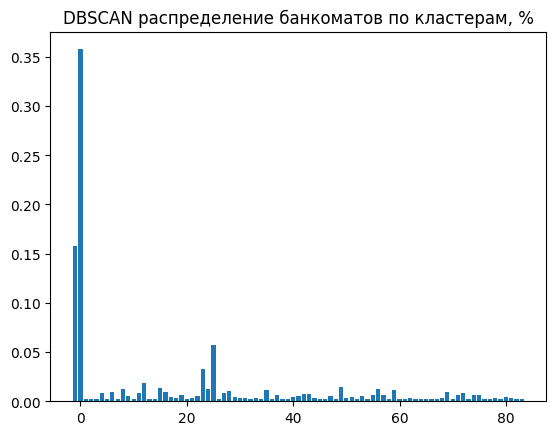

In [15]:
# считаем картезиановы координаты банкоматов

coords_df = helpers.calc_cartesian_coords(lat_series=geo_df['latitude'],
                                          lon_series=geo_df['longitude'])
coords_df = geo_df.join(coords_df)

# теперь мы кластеризуем банкоматы
dbscan_eps = 2000
dbscan = DBSCAN(eps=dbscan_eps, min_samples=3)
labels = dbscan.fit_predict(coords_df[['x', 'y']], sample_weight=None)
coords_df['dbscan_label'] = labels

# смотрим распределение банкоматов по кластерам
bsplot.plot_clusters_size(coords_df['dbscan_label'], title='DBSCAN распределение банкоматов по кластерам, %')

In [16]:
bsplot.geoplot_clusters(coords_df, 'dbscan_label', html_folder=INTERIM_DATA_FOLDER)

### KMeans

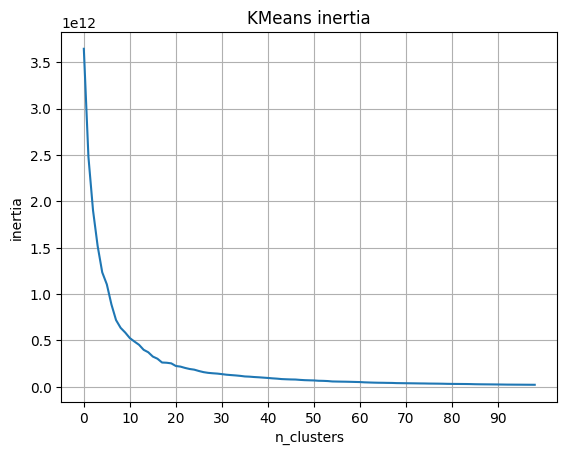

In [6]:
inertia = []

for i in range(1, 100):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=RS)
    kmeans.fit_predict(coords_df[['x', 'y']])
    inertia.append(kmeans.inertia_)

plt.plot(inertia)
plt.title('KMeans inertia')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.xticks(range(0, 100, 10))
plt.grid()
plt.show()

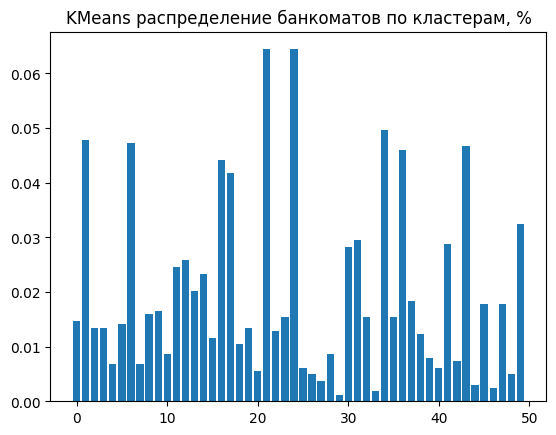

In [7]:
kmeans = KMeans(n_clusters=50, n_init='auto', random_state=RS)
labels = kmeans.fit_predict(coords_df[['x', 'y']], sample_weight=None)
coords_df['kmeans_label'] = labels

# смотрим распределение банкоматов по кластерам
bsplot.plot_clusters_size(coords_df['kmeans_label'], title='KMeans распределение банкоматов по кластерам, %')

In [8]:
bsplot.geoplot_clusters(coords_df, 'kmeans_label', html_folder=INTERIM_DATA_FOLDER)